In [332]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from pathlib import Path
from glob import glob
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [333]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    Linewidth_glass = glass_data['linewidth'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.96
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    dLinewidth_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_data)
        if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
            dEres_IG_list.append(dEres_IG.values)
            dLinewidth_IG_list.append(dLinewidth_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
    C = dEres_IG_mean / dnsub_IG
    D = dLinewidth_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    target_Linewidth = D*(target_nsub - glass_nsub) + glass_data['linewidth']
    return target_Eres, target_Linewidth

In [334]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

(1701, 7)


In [335]:
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)
print(exp_ito_data.shape)

exp_ito_data = exp_ito_data[(exp_ito_data['length'] > 75) & (exp_ito_data['length'] < 100)] 
exp_ito_data = exp_ito_data[(exp_ito_data['width'] > 27) & (exp_ito_data['width'] < 32)] 
exp_ito_data = exp_ito_data.reset_index(drop=True)
print(exp_ito_data.shape)

# exp_ito_data = exp_ito_data[(exp_ito_data['length'] > 75) & (exp_ito_data['length'] < 95)] 
# exp_ito_data = exp_ito_data[(exp_ito_data['width'] > 29) & (exp_ito_data['width'] < 31)] 
# exp_ito_data = exp_ito_data.reset_index(drop=True)
# print(exp_ito_data.shape)

(148, 11)
(106, 11)


(106, 11)


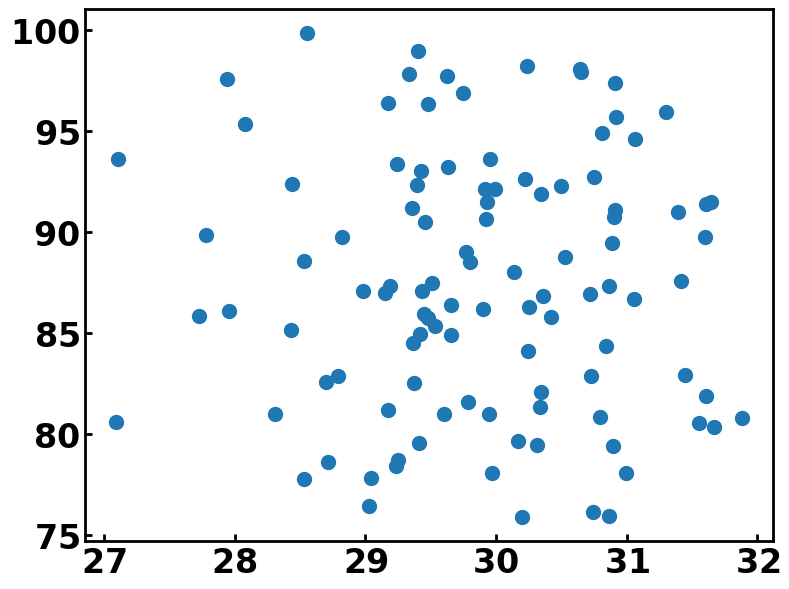

In [161]:
plt.scatter(exp_ito_data['width'], exp_ito_data['length'])
print(exp_ito_data.shape)

In [336]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

# ito_data = ito_data.sample(1000, random_state=42)
# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']
print(X_ito.shape)

(1701, 2)
(3292, 2)


In [337]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Figure 3A 3B

In [133]:
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)

exp_ito_data = exp_ito_data[(exp_ito_data['length'] > 80) & (exp_ito_data['length'] < 95)] 
exp_ito_data = exp_ito_data[(exp_ito_data['width'] > 28) & (exp_ito_data['width'] < 31)] 
exp_ito_data = exp_ito_data.reset_index(drop=True)
print(exp_ito_data.shape)

# create the specific number of data
# exp_glass_data = exp_glass_data.sample(50, random_state=42)
exp_ito_data = exp_ito_data.sample(30, random_state=42)
exp_ito_data = exp_ito_data.reset_index(drop=True)

X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
yw_exp_ito = exp_ito_data['width']
yl_exp_ito = exp_ito_data['length']
print(X_exp_ito.shape)

(59, 11)
(30, 2)


## Glass to ITO again

In [128]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

# ito_data = ito_data.sample(1000, random_state=42)
# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']
print(X_ito.shape)

(1701, 2)
(3292, 2)


In [129]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_exp_ito)

rel_errw1 = (abs(yw_exp_ito-yw_pred1)/yw_exp_ito)*100
rmspew1 = (sum(rel_errw1**2)/len(yw_pred1)) ** 0.5
maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_exp_ito)

rel_errl1 = (abs(yl_exp_ito-yl_pred1)/yl_exp_ito)*100
rmspel1 = (sum(rel_errl1**2)/len(yl_pred1)) ** 0.5
mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)

print(rmspew1, rmspel1)
print(maew1, mael1)

7.287475207036923 12.350378904430883
1.7321221389721393 9.52287574927462


## Corr. Glass to ITO 

In [130]:
ITO_nsub = 1.96
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, combined_data, target_nsub=ITO_nsub)

X_glass['eres'] = ITO_Eres
X_glass['linewidth'] = ITO_Linewidth
print(X_glass.head())

       eres  linewidth
0  1.930700   0.157127
1  1.635627   0.100955
2  1.736884   0.105641
3  1.551191   0.090922
4  1.805388   0.121025


In [131]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred2 = gsw.predict(X_exp_ito)

rel_errw2 = (abs(yw_exp_ito-yw_pred2)/yw_exp_ito)*100
rmspew2 = (sum(rel_errw2**2)/len(yw_pred2)) ** 0.5
maew2 = mean_absolute_error(yw_exp_ito, yw_pred2)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred2 = gsl.predict(X_exp_ito)

rel_errl2 = (abs(yl_exp_ito-yl_pred2)/yl_exp_ito)*100
rmspel2 = (sum(rel_errl2**2)/len(yl_pred2)) ** 0.5
mael2 = mean_absolute_error(yl_exp_ito, yl_pred2)

print(rmspew2, rmspel2)
print(maew2, mael2)

11.12924499222028 8.999431698849309
2.8337400675250675 6.9398439586339595


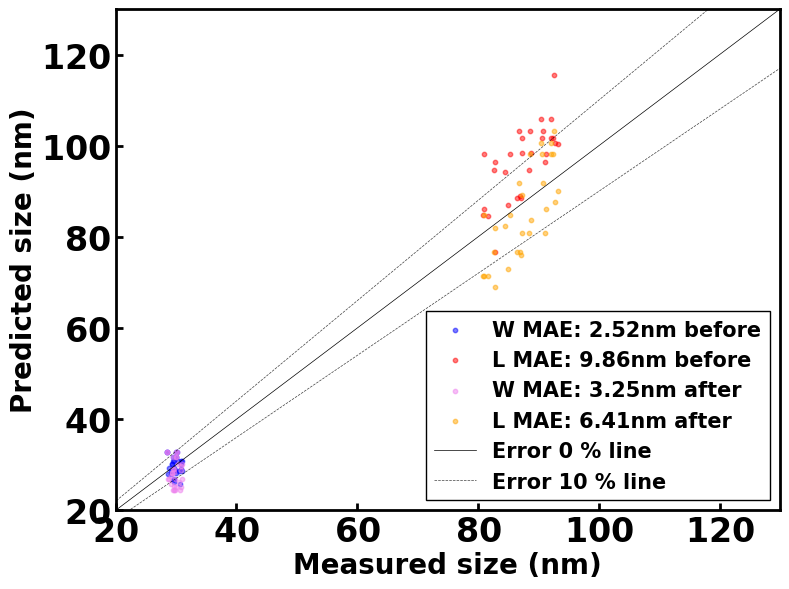

In [132]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, yw_pred1, s=10, c='b', alpha=.5, label=f'W MAE: {round(maew1_array.mean(), 2)}nm before')
ax.scatter(yl_exp_ito, yl_pred1, s=10, c='r', alpha=.5, label=f'L MAE: {round(mael1_array.mean(), 2)}nm before')

ax.scatter(yw_exp_ito, yw_pred2, s=10, c='violet', alpha=.5, label=f'W MAE: {round(maew2_array.mean(), 2)}nm after')
ax.scatter(yl_exp_ito, yl_pred2, s=10, c='orange', alpha=.5, label=f'L MAE: {round(mael2_array.mean(), 2)}nm after')

x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(20, 130)
ax.set_ylim(20, 130)
ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'B', ha='left', va='top', transform=ax.transAxes, fontsize=30)

(-30.000, 30.000)

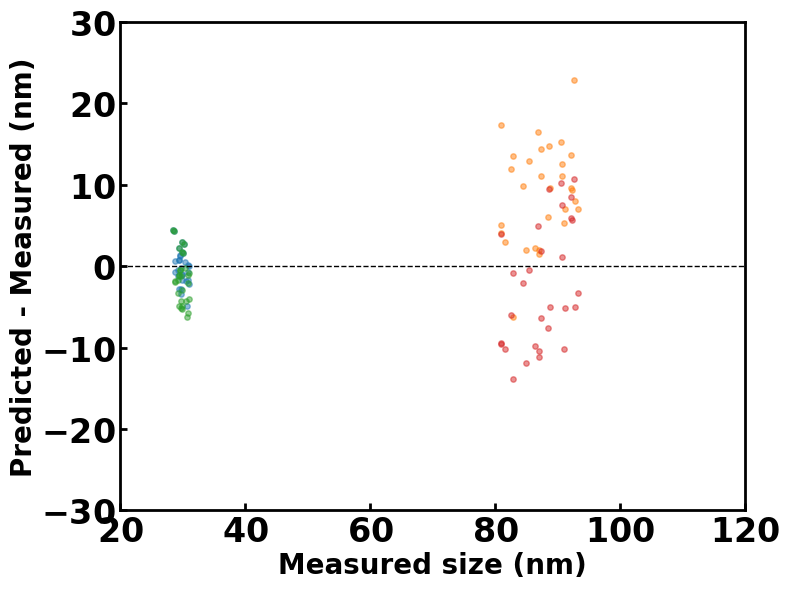

In [136]:
fig, ax = plt.subplots()

# Glass to ITO
ax.scatter(yw_exp_ito, yw_pred1-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
ax.scatter(yl_exp_ito, yl_pred1-yl_exp_ito, s=15, alpha=.5, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
ax.scatter(yw_exp_ito, yw_pred2-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
ax.scatter(yl_exp_ito, yl_pred2-yl_exp_ito, s=15, alpha=.5, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

# for i in range(len(yw_exp_ito)):
#     ax.plot([yw_exp_ito[i], yw_exp_ito[i]], [yw_pred1[i] - yw_exp_ito[i], yw_pred2[i] - yw_exp_ito[i]], color='gray', alpha=0.5)

# for i in range(len(yl_exp_ito)):
#     ax.plot([yl_exp_ito[i], yl_exp_ito[i]], [yl_pred1[i] - yl_exp_ito[i], yl_pred2[i] - yl_exp_ito[i]], color='gray', alpha=0.5)    
    
ax.axhline(y=0, lw=1, ls="--", c='k')

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Predicted - Measured (nm)')
ax.set_xlim(20, 120)
ax.set_ylim(-30, 30)
# ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

# Figure 3C

## Glass to ITO

In [338]:
maew1_array = np.array([])
mael1_array = np.array([])
yw_pred1_df = pd.DataFrame()
yl_pred1_df = pd.DataFrame()

num_model = 15
for i in tqdm(range(num_model)):
    # create the specific number of data
    exp_ito_data_sampled = exp_ito_data.sample(30, random_state=i)
    exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

    X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data_sampled['width']
    yl_exp_ito = exp_ito_data_sampled['length']

    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_glass, yw_glass)
    yw_pred1 = gsw.predict(X_exp_ito)
    yw_pred1_df = pd.concat([yw_pred1_df, pd.DataFrame(yw_pred1)], axis=1, sort=True)
    maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)
    maew1_array = np.append(maew1_array, maew1)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_glass, yl_glass)
    yl_pred1 = gsl.predict(X_exp_ito)
    yl_pred1_df = pd.concat([yl_pred1_df, pd.DataFrame(yl_pred1)], axis=1, sort=True)
    mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)
    mael1_array = np.append(mael1_array, mael1)
    
yw_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:53<00:00,  3.57s/it]


## Corr. Glass to ITO

In [339]:
ITO_nsub = 1.96
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, combined_data, target_nsub=ITO_nsub)
X_glass['eres'] = ITO_Eres
# X_glass['linewidth'] = ITO_Linewidth

In [340]:
maew2_array = np.array([])
mael2_array = np.array([])
yw_pred2_df = pd.DataFrame()
yl_pred2_df = pd.DataFrame()

for i in tqdm(range(num_model)):
    # create the specific number of data
    exp_ito_data_sampled = exp_ito_data.sample(30, random_state=i)
    exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

    X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data_sampled['width']
    yl_exp_ito = exp_ito_data_sampled['length']

    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_glass, yw_glass)
    yw_pred2 = gsw.predict(X_exp_ito)
    yw_pred2_df = pd.concat([yw_pred2_df, pd.DataFrame(yw_pred2)], axis=1, sort=True)

    maew2 = mean_absolute_error(yw_exp_ito, yw_pred2)
    maew2_array = np.append(maew2_array, maew2)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_glass, yl_glass)
    yl_pred2 = gsl.predict(X_exp_ito)
    yl_pred2_df = pd.concat([yl_pred2_df, pd.DataFrame(yl_pred2)], axis=1, sort=True)
    mael2 = mean_absolute_error(yl_exp_ito, yl_pred2)
    mael2_array = np.append(mael2_array, mael2)
    
yw_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:55<00:00,  3.67s/it]


## ITO to ITO

In [341]:
maew3_array = np.array([])
mael3_array = np.array([])
yw_pred3_df = pd.DataFrame()
yl_pred3_df = pd.DataFrame()

for i in tqdm(range(15)):
    # create the specific number of data
    exp_ito_data_sampled = exp_ito_data.sample(30, random_state=i)
    exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

    X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data_sampled['width']
    yl_exp_ito = exp_ito_data_sampled['length']

    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_ito, yw_ito)
    yw_pred3 = gsw.predict(X_exp_ito)
    yw_pred3_df = pd.concat([yw_pred3_df, pd.DataFrame(yw_pred3)], axis=1, sort=True)
    maew3 = mean_absolute_error(yw_exp_ito, yw_pred3)
    maew3_array = np.append(maew3_array, maew3)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_ito, yl_ito)
    yl_pred3 = gsl.predict(X_exp_ito)
    yl_pred3_df = pd.concat([yl_pred3_df, pd.DataFrame(yl_pred3)], axis=1, sort=True)
    mael3 = mean_absolute_error(yl_exp_ito, yl_pred3)
    mael3_array = np.append(mael3_array, mael3)

yw_pred3_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred3_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [01:28<00:00,  5.87s/it]


## Error distribution plots

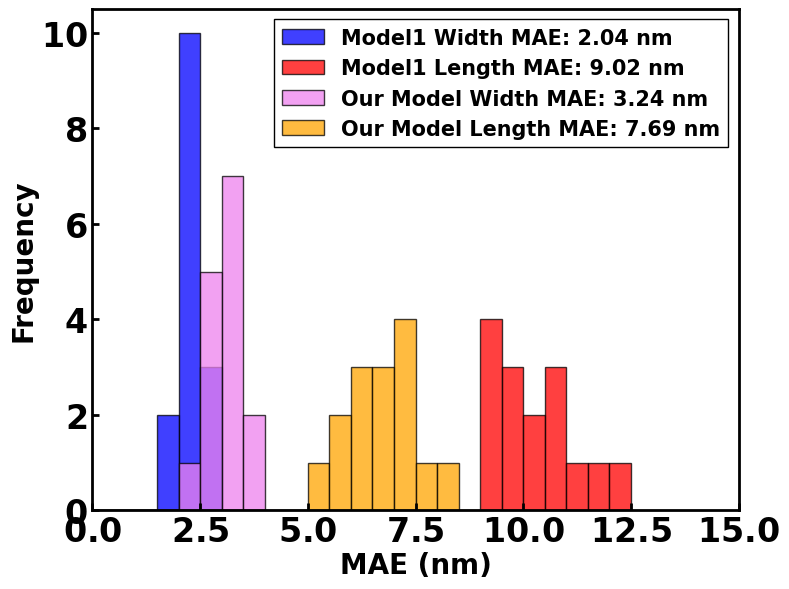

In [182]:
fig, ax = plt.subplots()

# Glass to ITO
bin_width = .5
target1 = maew1_array
bins1 = np.arange(0, max(target1) + bin_width, bin_width)
ax.hist(target1, bins=bins1, color='blue', edgecolor='black', alpha=0.75, label=f'Model1 Width MAE: {round(maew1, 2)} nm')

target2 = mael1_array
bins2 = np.arange(0, max(target2) + bin_width, bin_width)
ax.hist(target2, bins=bins2, color='red', edgecolor='black', alpha=0.75, label=f'Model1 Length MAE: {round(mael1, 2)} nm')

# Corrected Glass to ITO
target3 = maew2_array 
bins3 = np.arange(0, max(target3) + bin_width, bin_width)
ax.hist(target3, bins=bins3, color='violet', edgecolor='black', alpha=0.75, label=f'Our Model Width MAE: {round(maew2, 2)} nm')

target4 = mael2_array
bins4 = np.arange(0, max(target4) + bin_width, bin_width)
ax.hist(target4, bins=bins4, color='orange', edgecolor='black', alpha=0.75, label=f'Our Model Length MAE: {round(mael2, 2)} nm')

ax.set_xlabel('MAE (nm)')
ax.set_ylabel('Frequency')
ax.set_xlim(0, 15)
# ax.set_ylim(10, 130)
ax.legend(loc='upper right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

In [211]:
target_array1 = np.array([])  
target_array2 = np.array([]) 
target_array3 = np.array([])  
target_array4 = np.array([]) 

# Loop through the 15 models and append each result to target_array
for i in tqdm(range(1, yw_pred1_df.shape[1]+1)):
    target1 = yw_pred1_df[f'model{i}'] - yw_exp_ito
    target_array1 = np.append(target_array1, target1)
    
    target2 = yl_pred1_df[f'model{i}'] - yl_exp_ito
    target_array2 = np.append(target_array2, target2)
    
    target3 = yw_pred2_df[f'model{i}'] - yw_exp_ito
    target_array3 = np.append(target_array3, target3)
    
    target4 = yl_pred2_df[f'model{i}'] - yl_exp_ito
    target_array4 = np.append(target_array4, target4)

100%|██████████| 15/15 [00:00<00:00, 2351.33it/s]


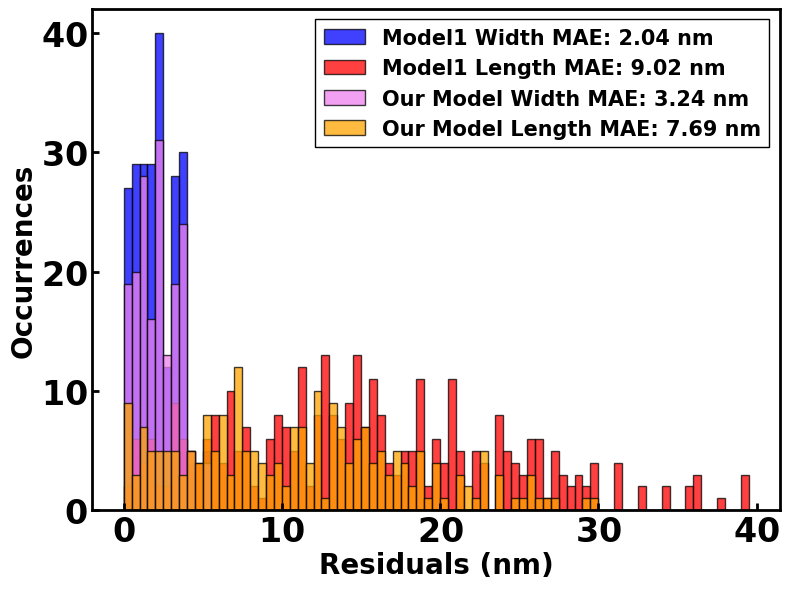

In [214]:
fig, ax = plt.subplots()

# Glass to ITO
bin_width = .5
target1 = target_array1
bins1 = np.arange(0, max(target1) + bin_width, bin_width)
ax.hist(target1, bins=bins1, color='blue', edgecolor='black', alpha=0.75, label=f'Model1 Width MAE: {round(maew1, 2)} nm')

target2 = target_array2
bins2 = np.arange(0, max(target2) + bin_width, bin_width)
ax.hist(target2, bins=bins2, color='red', edgecolor='black', alpha=0.75, label=f'Model1 Length MAE: {round(mael1, 2)} nm')

# Corrected Glass to ITO
target3 = target_array3
bins3 = np.arange(0, max(target3) + bin_width, bin_width)
ax.hist(target3, bins=bins3, color='violet', edgecolor='black', alpha=0.75, label=f'Our Model Width MAE: {round(maew2, 2)} nm')

target4 = target_array4
bins4 = np.arange(0, max(target4) + bin_width, bin_width)
ax.hist(target4, bins=bins4, color='orange', edgecolor='black', alpha=0.75, label=f'Our Model Length MAE: {round(mael2, 2)} nm')

ax.set_xlabel('Residuals (nm)')
ax.set_ylabel('Occurrences')
# ax.set_xlim(0, 15)
# ax.set_ylim(10, 130)
ax.legend(loc='upper right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

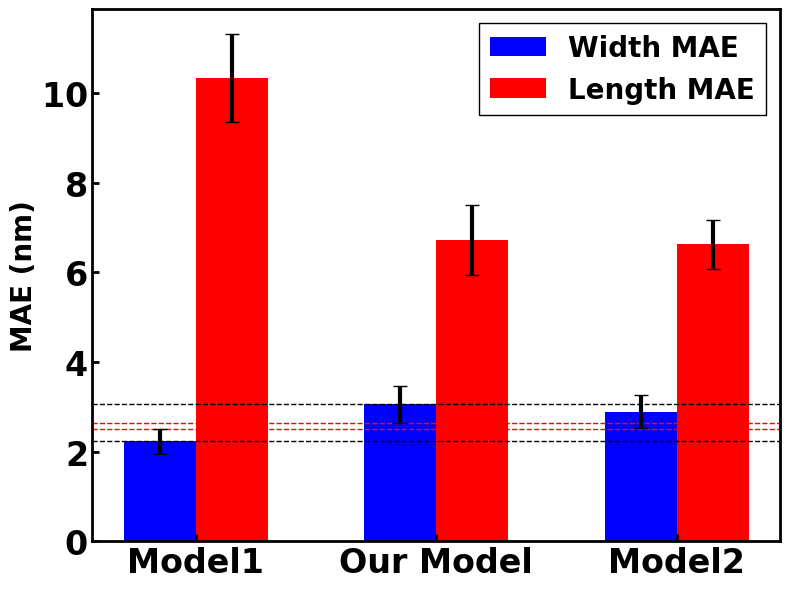

In [228]:
fig, ax = plt.subplots()

Width_MAE = (maew1_array.mean(), maew2_array.mean(), maew3_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean(), mael3_array.mean())

Width_MAE_errors = (maew1_array.std(), maew2_array.std(), maew3_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std(), mael3_array.std())

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax.axhline(y=maew1_array.mean(), lw=1, ls='--', c='k')
ax.axhline(y=maew2_array.mean(), lw=1, ls='--', c='k')

ax.axhline(y=maew1_array.mean()+maew1_array.std(), lw=1, ls='--', c='r')
ax.axhline(y=maew2_array.mean()-maew2_array.std(), lw=1, ls='--', c='r')


ax.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

plt.xticks(index, ('Model1', 'Our Model', 'Model2'))
ax.set_ylabel('MAE (nm)')

labels = ax.get_xticklabels()
plt.legend(fontsize=20)

In [342]:
model_to_vis = mael1_array.argmin()
# model_to_vis = 14
yw_pred1 = yw_pred1_df['model' + str(model_to_vis+1)]
yl_pred1 = yl_pred1_df['model' + str(model_to_vis+1)]

yw_pred2 = yw_pred2_df['model' + str(model_to_vis+1)]
yl_pred2 = yl_pred2_df['model' + str(model_to_vis+1)]

(40.000, 140.000)

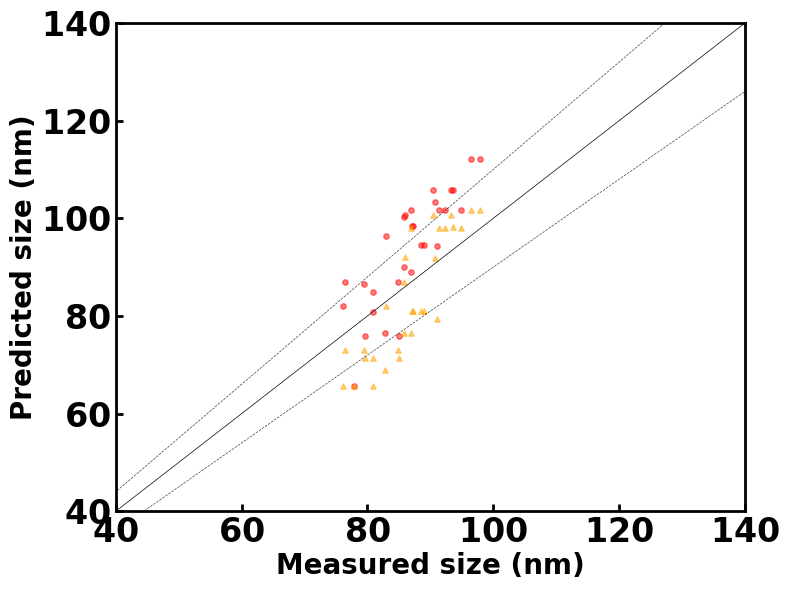

In [171]:
fig, ax = plt.subplots()

# ax.scatter(yw_exp_ito, yw_pred1, s=10, c='b', alpha=.5, label=f'W MAE: {round(maew1_array.mean(), 2)}nm before')
ax.scatter(yl_exp_ito, yl_pred1, s=15, c='r', alpha=.5, label=f'L MAE: {round(mael1_array.mean(), 2)}nm before')

# ax.scatter(yw_exp_ito, yw_pred2, s=10, c='violet', alpha=.5, label=f'W MAE: {round(maew2_array.mean(), 2)}nm after')
ax.scatter(yl_exp_ito, yl_pred2, s=15, c='orange', marker='^', alpha=.5, label=f'L MAE: {round(mael2_array.mean(), 2)}nm after')

x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(40, 140)
ax.set_ylim(40, 140)
# ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'B', ha='left', va='top', transform=ax.transAxes, fontsize=30)

(-20.000, 20.000)

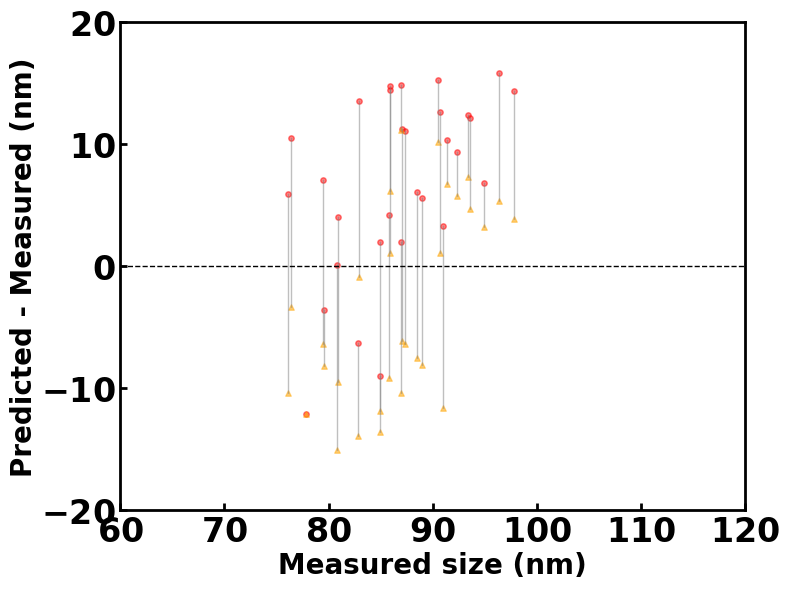

In [172]:
fig, ax = plt.subplots()

# Glass to ITO
# ax.scatter(yw_exp_ito, yw_pred1-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
ax.scatter(yl_exp_ito, yl_pred1-yl_exp_ito, s=15, c='r', alpha=.5, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
# ax.scatter(yw_exp_ito, yw_pred2-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
ax.scatter(yl_exp_ito, yl_pred2-yl_exp_ito, s=15, c='orange', marker='^', alpha=.5, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

# for i in range(len(yw_exp_ito)):
#     ax.plot([yw_exp_ito[i], yw_exp_ito[i]], [yw_pred1[i] - yw_exp_ito[i], yw_pred2[i] - yw_exp_ito[i]], color='gray', lw=1, alpha=0.5)

for i in range(len(yl_exp_ito)):
    ax.plot([yl_exp_ito[i], yl_exp_ito[i]], [yl_pred1[i] - yl_exp_ito[i], yl_pred2[i] - yl_exp_ito[i]], color='gray', lw=1, alpha=0.5)    
    
ax.axhline(y=0, lw=1, ls="--", c='k')

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Predicted - Measured (nm)')
ax.set_xlim(60, 120)
ax.set_ylim(-20, 20)
# ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

(-20.000, 20.000)

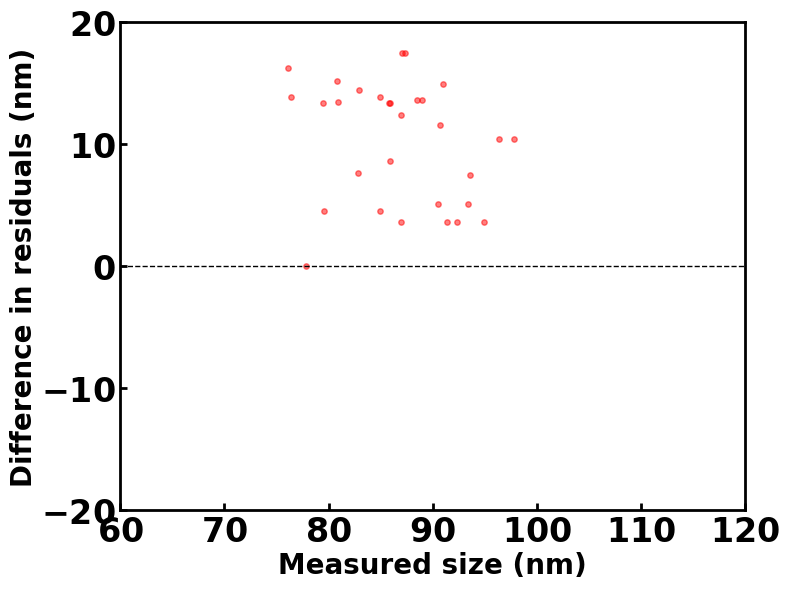

In [286]:
fig, ax = plt.subplots()

# Glass to ITO
# ax.scatter(yw_exp_ito, yw_pred1-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
ax.scatter(yl_exp_ito, (yl_pred1-yl_exp_ito) - (yl_pred2-yl_exp_ito), s=15, c='r', alpha=.5, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
# ax.scatter(yw_exp_ito, yw_pred2-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
# ax.scatter(yl_exp_ito, yl_pred2-yl_exp_ito, s=15, c='orange', marker='^', alpha=.5, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

ax.axhline(y=0, lw=1, ls="--", c='k')

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Difference in residuals (nm)')
ax.set_xlim(60, 120)
ax.set_ylim(-20, 20)
# ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

(-5.000, 5.000)

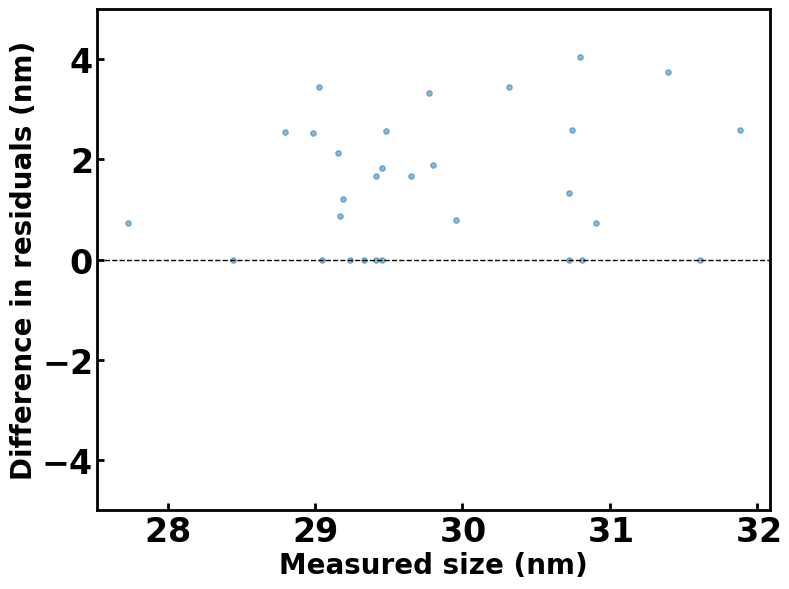

In [288]:
fig, ax = plt.subplots()

# Glass to ITO
ax.scatter(yw_exp_ito, (yw_pred1-yw_exp_ito) - (yw_pred2-yw_exp_ito), s=15, alpha=.5, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
# ax.scatter(yl_exp_ito, (yl_pred1-yl_exp_ito) - (yl_pred2-yl_exp_ito), s=15, c='r', alpha=.5, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
# ax.scatter(yw_exp_ito, yw_pred2-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
# ax.scatter(yl_exp_ito, yl_pred2-yl_exp_ito, s=15, c='orange', marker='^', alpha=.5, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

ax.axhline(y=0, lw=1, ls="--", c='k')

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Difference in residuals (nm)')
# ax.set_xlim(60, 120)
ax.set_ylim(-5, 5)
# ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

Text(-0.13, 1, 'B')

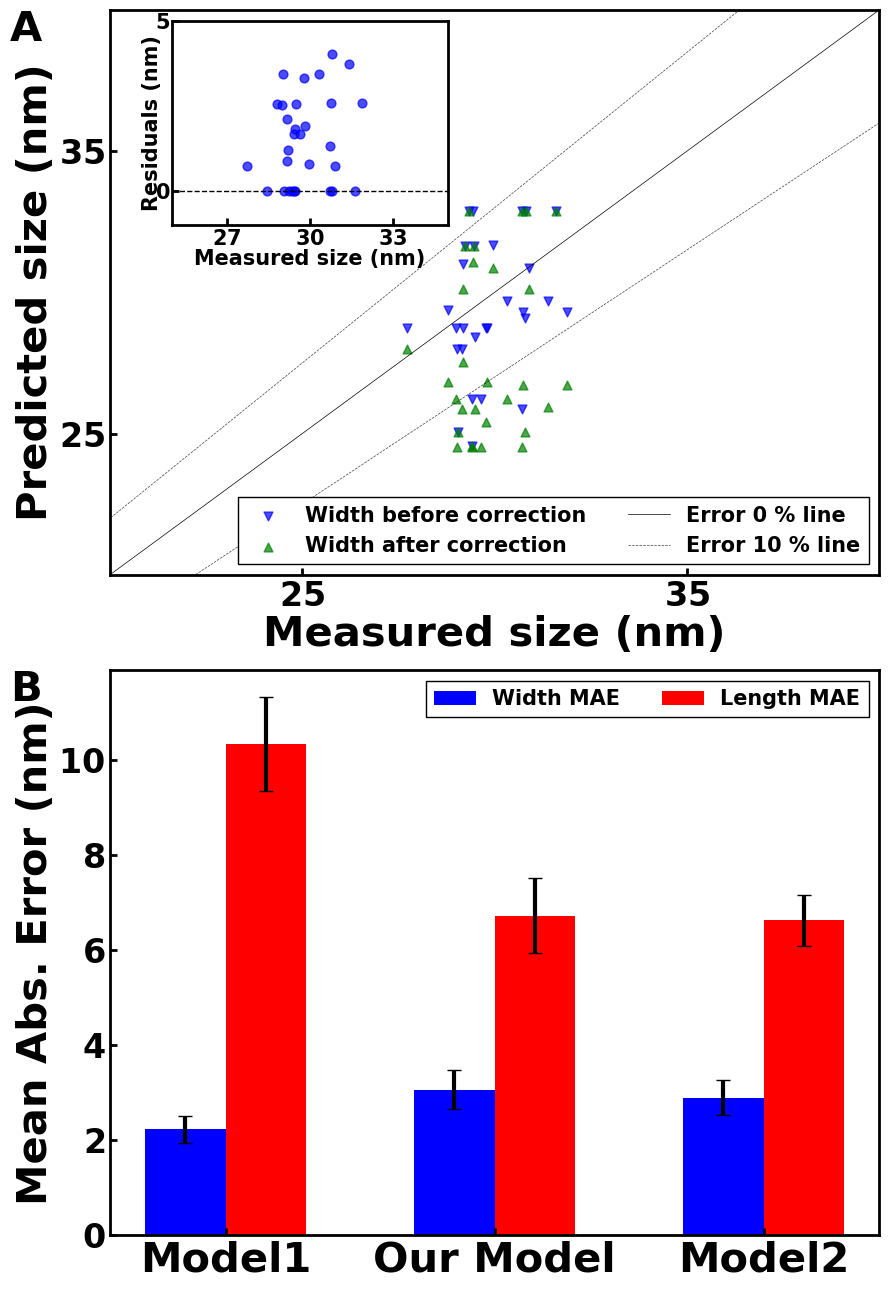

In [298]:
# Create the figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 13), dpi=100)  # 1 row, 2 columns

# First subplot
ax1.scatter(yw_exp_ito, yw_pred1, s=40, c='b', marker='v', alpha=.7, label=f'Width before correction')
# ax1.scatter(yl_exp_ito, yl_pred1, s=40, c='r', marker='v', alpha=.7, label=f'Length before correction')

ax1.scatter(yw_exp_ito, yw_pred2, s=40, c='g', marker='^', alpha=.7, label=f'Width after correction')
# ax1.scatter(yl_exp_ito, yl_pred2, s=40, c='g', marker='^', alpha=.7, label=f'Length after correction')

x = np.arange(-1, 181)
ax1.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax1.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax1.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax1.set_xticks([25, 35])
ax1.set_yticks([25, 35])
ax1.set_xlabel('Measured size (nm)', fontsize=30)
ax1.set_ylabel('Predicted size (nm)', fontsize=30)
ax1.set_xlim(20, 40)
ax1.set_ylim(20, 40)
ax1.legend(loc='lower right', fontsize=15, ncols=2)
ax1.text(-0.13, 1, 'A', ha='left', va='top', transform=ax1.transAxes, fontsize=30)

# add_axes([left, bottom, width, height]) values are fractions of fig width and height
axins = ax1.inset_axes([0.08, 0.62, 0.36, 0.36])

# Plot on inset
# Glass to ITO
axins.scatter(yw_exp_ito, yw_pred1 - yw_pred2, s=40, c='b', alpha=.7, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
# axins.scatter(yl_exp_ito, yl_pred1-yl_exp_ito, s=40, c='r', marker='v', alpha=.7, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
# axins.scatter(yw_exp_ito, yw_pred2-yw_exp_ito, s=40, c='g', marker='^', alpha=.7, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
# axins.scatter(yl_exp_ito, yl_pred2-yl_exp_ito, s=40, c='g', marker='^', alpha=.7, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

# for i in range(len(yw_exp_ito)):
#     axins.plot([yw_exp_ito[i], yw_exp_ito[i]], [yw_pred1[i] - yw_exp_ito[i], yw_pred2[i] - yw_exp_ito[i]], color='gray', lw=1, alpha=0.5)

# for i in range(len(yl_exp_ito)):
#     axins.plot([yl_exp_ito[i], yl_exp_ito[i]], [yl_pred1[i] - yl_exp_ito[i], yl_pred2[i] - yl_exp_ito[i]], color='gray', lw=1, alpha=0.5)

axins.axhline(y=0, lw=1, ls="--", c='k')
axins.set_xlabel('Measured size (nm)', fontsize=15, labelpad=0)
axins.set_ylabel('Residuals (nm)', fontsize=15, labelpad=-5)
axins.set_xticks([27, 30, 33])
axins.set_yticks([-5, 0, 5])
axins.tick_params(axis='x', labelsize=15, pad=3)
axins.tick_params(axis='y', labelsize=15, pad=1) 
axins.set_xlim(25, 35)
axins.set_ylim(-1, 5)

# Second subplot
Width_MAE = (maew1_array.mean(), maew2_array.mean(), maew3_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean(), mael3_array.mean())

Width_MAE_errors = (maew1_array.std(), maew2_array.std(), maew3_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std(), mael3_array.std())

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax2.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax2.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

ax2.set_xticks(index, ('Model1', 'Our Model', 'Model2'), fontsize=30)
ax2.set_ylabel('Mean Abs. Error (nm)', fontsize=30)
ax2.legend(fontsize=15, ncols=2)
ax2.text(-0.13, 1, 'B', ha='left', va='top', transform=ax2.transAxes, fontsize=30)

Text(-0.13, 1, 'B')

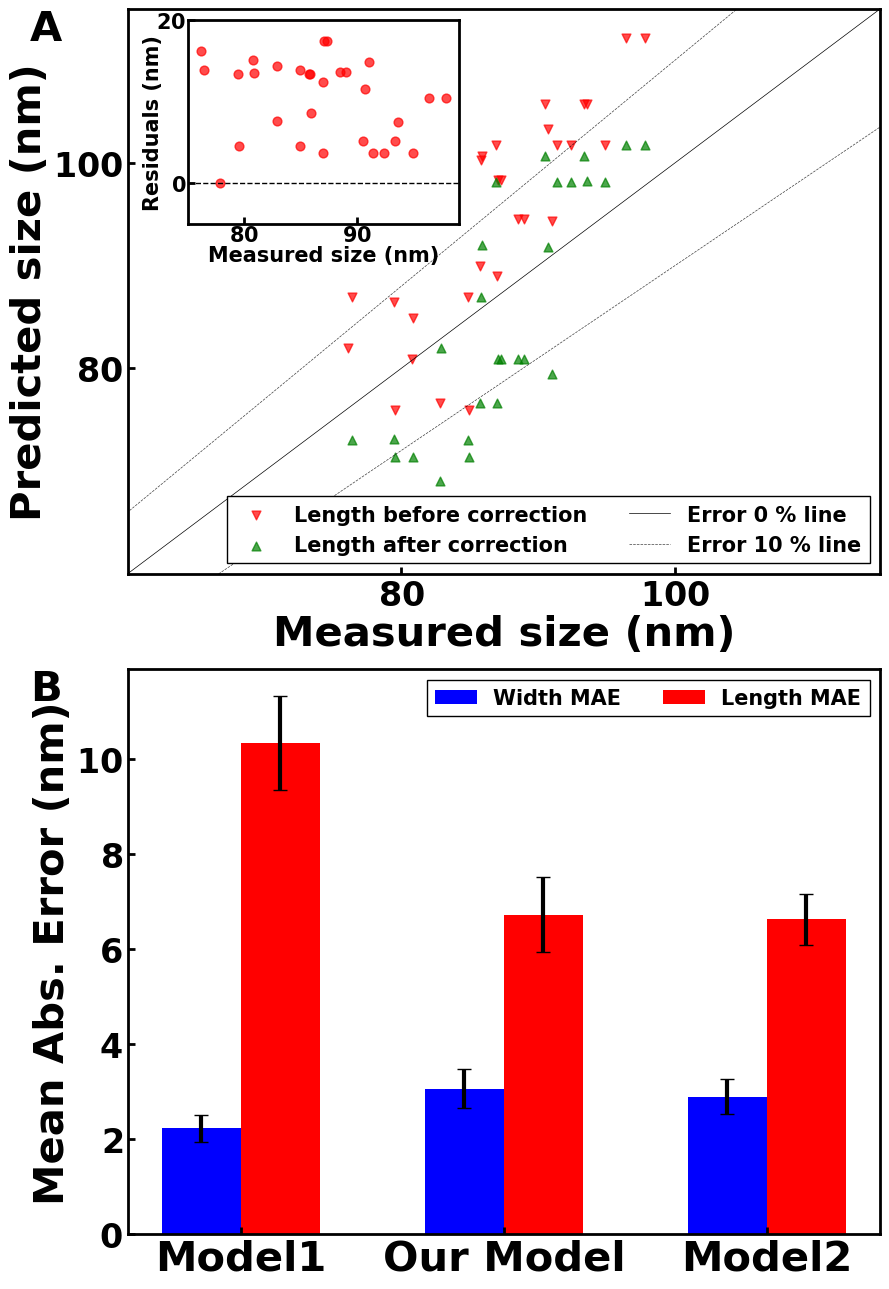

In [295]:
# Create the figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 13), dpi=100)  # 1 row, 2 columns

# First subplot
# ax1.scatter(yw_exp_ito, yw_pred1, s=10, c='b', alpha=.5, label=f'W MAE: {round(maew1_array.mean(), 2)}nm before')
ax1.scatter(yl_exp_ito, yl_pred1, s=40, c='r', marker='v', alpha=.7, label=f'Length before correction')

# ax1.scatter(yw_exp_ito, yw_pred2, s=10, c='violet', alpha=.5, label=f'W MAE: {round(maew2_array.mean(), 2)}nm after')
ax1.scatter(yl_exp_ito, yl_pred2, s=40, c='g', marker='^', alpha=.7, label=f'Length after correction')

x = np.arange(-1, 181)
ax1.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax1.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax1.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax1.set_xticks([80, 100])
ax1.set_yticks([80, 100])
ax1.set_xlabel('Measured size (nm)', fontsize=30)
ax1.set_ylabel('Predicted size (nm)', fontsize=30)
ax1.set_xlim(60, 115)
ax1.set_ylim(60, 115)
ax1.legend(loc='lower right', fontsize=15, ncols=2)
ax1.text(-0.13, 1, 'A', ha='left', va='top', transform=ax1.transAxes, fontsize=30)

# add_axes([left, bottom, width, height]) values are fractions of fig width and height
axins = ax1.inset_axes([0.08, 0.62, 0.36, 0.36])

# Plot on inset
# Glass to ITO
# axins.scatter(yw_exp_ito, yw_pred1-yw_exp_ito, s=10, c='b', alpha=.5, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
axins.scatter(yl_exp_ito, yl_pred1 - yl_pred2, s=40, c='r', alpha=.7, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
# axins.scatter(yw_exp_ito, yw_pred2-yw_exp_ito, s=10, c='violet', alpha=.5, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
# axins.scatter(yl_exp_ito, yl_pred2-yl_exp_ito, s=40, c='g', marker='^', alpha=.7, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

# for i in range(len(yw_exp_ito)):
#     axins.plot([yw_exp_ito[i], yw_exp_ito[i]], [yw_pred1[i] - yw_exp_ito[i], yw_pred2[i] - yw_exp_ito[i]], color='gray', lw=1, alpha=0.5)

# for i in range(len(yl_exp_ito)):
#     axins.plot([yl_exp_ito[i], yl_exp_ito[i]], [yl_pred1[i] - yl_exp_ito[i], yl_pred2[i] - yl_exp_ito[i]], color='gray', lw=1, alpha=0.5)

axins.axhline(y=0, lw=1, ls="--", c='k')
axins.set_xlabel('Measured size (nm)', fontsize=15, labelpad=0)
axins.set_ylabel('Residuals (nm)', fontsize=15, labelpad=-5)
axins.set_xticks([80, 90])
axins.set_yticks([-20, 0, 20])
axins.tick_params(axis='x', labelsize=15, pad=1)
axins.tick_params(axis='y', labelsize=15, pad=1) 
axins.set_xlim(75, 99)
axins.set_ylim(-5, 20)

# Second subplot
Width_MAE = (maew1_array.mean(), maew2_array.mean(), maew3_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean(), mael3_array.mean())

Width_MAE_errors = (maew1_array.std(), maew2_array.std(), maew3_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std(), mael3_array.std())

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax2.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax2.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

ax2.set_xticks(index, ('Model1', 'Our Model', 'Model2'), fontsize=30)
ax2.set_ylabel('Mean Abs. Error (nm)', fontsize=30)
ax2.legend(fontsize=15, ncols=2)
ax2.text(-0.13, 1, 'B', ha='left', va='top', transform=ax2.transAxes, fontsize=30)

Text(-0.13, 1, 'C')

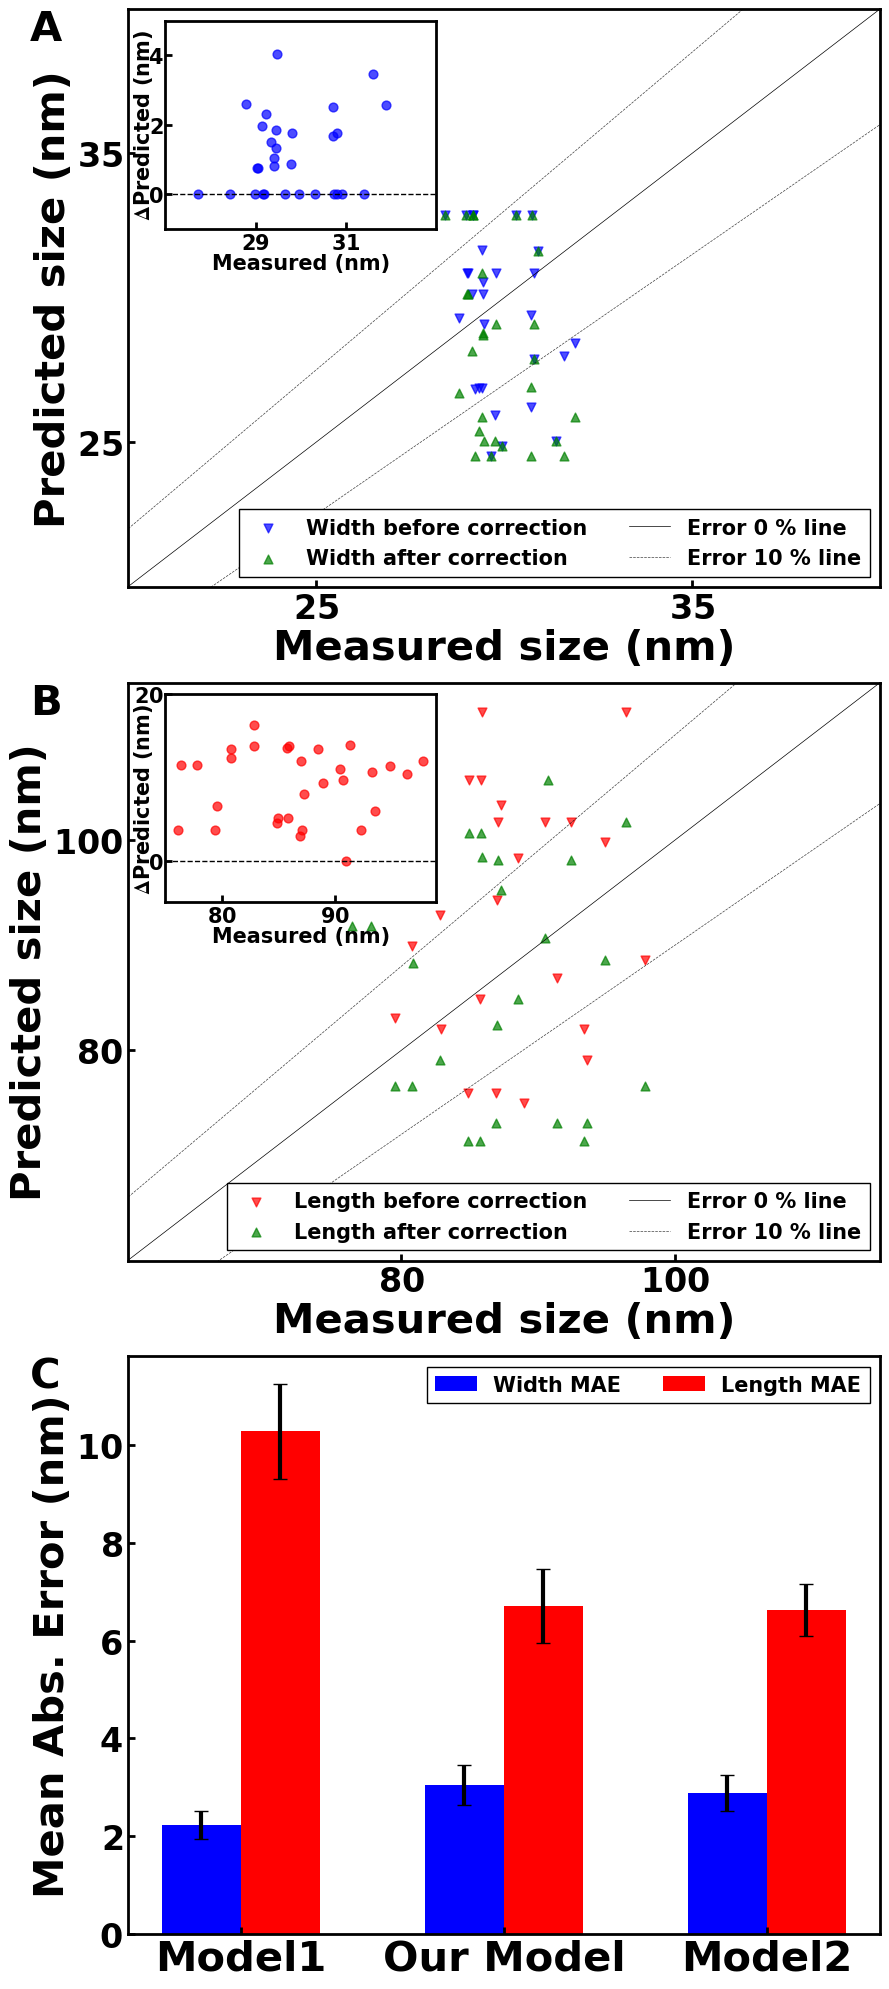

In [343]:
# Create the figure and a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 20), dpi=100)  # 1 row, 2 columns

# First subplot
ax1.scatter(yw_exp_ito, yw_pred1, s=40, c='b', marker='v', alpha=.7, label=f'Width before correction')
ax1.scatter(yw_exp_ito, yw_pred2, s=40, c='g', marker='^', alpha=.7, label=f'Width after correction')

x = np.arange(-1, 181)
ax1.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax1.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax1.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax1.set_xticks([25, 35])
ax1.set_yticks([25, 35])
ax1.set_xlabel('Measured size (nm)', fontsize=30)
ax1.set_ylabel('Predicted size (nm)', fontsize=30)
ax1.set_xlim(20, 40)
ax1.set_ylim(20, 40)
ax1.legend(loc='lower right', fontsize=15, ncols=2)
ax1.text(-0.13, 1, 'A', ha='left', va='top', transform=ax1.transAxes, fontsize=30)

# add_axes([left, bottom, width, height]) values are fractions of fig width and height
ax1ins = ax1.inset_axes([0.05, 0.62, 0.36, 0.36])

# Plot on inset
ax1ins.scatter(yw_exp_ito, yw_pred1-yw_pred2, s=40, c='b', alpha=.7, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
ax1ins.axhline(y=0, lw=1, ls="--", c='k')
ax1ins.set_xlabel('Measured (nm)', fontsize=15, labelpad=0)
ax1ins.set_ylabel('$\Delta$Predicted (nm)', fontsize=15, labelpad=-5)
ax1ins.set_xticks([29, 31])
ax1ins.set_yticks([0, 2, 4])
ax1ins.tick_params(axis='x', labelsize=15, pad=3)
ax1ins.tick_params(axis='y', labelsize=15, pad=1) 
ax1ins.set_xlim(27, 33)
ax1ins.set_ylim(-1, 5)

# Second subplot
ax2.scatter(yl_exp_ito, yl_pred1, s=40, c='r', marker='v', alpha=.7, label=f'Length before correction')
ax2.scatter(yl_exp_ito, yl_pred2, s=40, c='g', marker='^', alpha=.7, label=f'Length after correction')

ax2.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax2.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax2.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax2.set_xticks([80, 100])
ax2.set_yticks([80, 100])
ax2.set_xlabel('Measured size (nm)', fontsize=30)
ax2.set_ylabel('Predicted size (nm)', fontsize=30)
ax2.set_xlim(60, 115)
ax2.set_ylim(60, 115)
ax2.legend(loc='lower right', fontsize=15, ncols=2)
ax2.text(-0.13, 1, 'B', ha='left', va='top', transform=ax2.transAxes, fontsize=30)

# add_axes([left, bottom, width, height]) values are fractions of fig width and height
ax2ins = ax2.inset_axes([0.05, 0.62, 0.36, 0.36])

# Plot on inset
ax2ins.scatter(yl_exp_ito, yl_pred1-yl_pred2, s=40, c='r', alpha=.7, label=f'MAE: {round(mael1_array.mean(), 2)} nm')
ax2ins.axhline(y=0, lw=1, ls="--", c='k')
ax2ins.set_xlabel('Measured (nm)', fontsize=15, labelpad=0)
ax2ins.set_ylabel('$\Delta$Predicted (nm)', fontsize=15, labelpad=-15)
ax2ins.set_xticks([80, 90])
ax2ins.set_yticks([-20, 0, 20])
ax2ins.tick_params(axis='x', labelsize=15, pad=3)
ax2ins.tick_params(axis='y', labelsize=15, pad=1) 
ax2ins.set_xlim(75, 99)
ax2ins.set_ylim(-5, 20)

# Third subplot
Width_MAE = (maew1_array.mean(), maew2_array.mean(), maew3_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean(), mael3_array.mean())

Width_MAE_errors = (maew1_array.std(), maew2_array.std(), maew3_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std(), mael3_array.std())

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax3.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax3.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

ax3.set_xticks(index, ('Model1', 'Our Model', 'Model2'), fontsize=30)
ax3.set_ylabel('Mean Abs. Error (nm)', fontsize=30)
ax3.legend(fontsize=15, ncols=2)
ax3.text(-0.13, 1, 'C', ha='left', va='top', transform=ax3.transAxes, fontsize=30)